Importações Iniciais - Manejo do Dataframe e depois para treinar o modelo

In [1]:
import pandas as pd
import numpy as np
from features import create
from datetime import datetime
from features.required import REQUIRED_FEATURES

In [2]:
from model import calculate
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from model.config import grid_search, random_search
from sklearn.metrics import mean_absolute_error, mean_squared_error

Pré-processamento inicial dos dados.

In [3]:
df = pd.read_csv(r'training_testing/dados/dados_eventos.csv')
df['date'] = pd.to_datetime(df['date'])
df.drop_duplicates()
df.sort_values(by='date')
df.info()

df = df.rename(columns= {
    'jogador_casa': 'home_player',
    'jogador_fora': 'away_player',
    'time_casa': 'home_team',
    'time_fora': 'away_team',
    'gols_casa': 'home_score',
    'gols_fora': 'away_score',
    'gols_totais': 'total_score',})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26884 entries, 0 to 26883
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event_id      26884 non-null  int64         
 1   date          26884 non-null  datetime64[ns]
 2   time_fora     26884 non-null  object        
 3   jogador_fora  26884 non-null  object        
 4   gols_fora     26860 non-null  float64       
 5   time_casa     26884 non-null  object        
 6   jogador_casa  26884 non-null  object        
 7   gols_casa     26860 non-null  float64       
 8   gols_totais   26860 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.8+ MB


Divisão dos dados e criação das features separadamente


In [4]:
# df = df[df['date'] >= pd.to_datetime('2025-03-01')]


In [5]:
#Dividir em Treino, Teste e Validação

train_size = int(0.6 * len(df))
val_size = int(0.2 * len(df))

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]


In [6]:
lookback_val = train_df
lookback_test = df.iloc[:len(test_df)]

In [7]:
#Criar Features para cada um dos dados.
#TODO: Normalizar?

train_featured = create.features(
    data=train_df,live=False
    ).dropna()

val_featured = create.features(
    data=val_df, live=False, 
    lookback_data=train_df
    ).dropna()

test_featured = create.features(
    data=test_df, live=False, 
    lookback_data=lookback_test
    ).dropna()

In [8]:
#Divisão dos dados em X e y

train_X = train_featured[REQUIRED_FEATURES]
train_y = train_featured['total_score']

val_X = test_featured[REQUIRED_FEATURES]
val_y = test_featured['total_score']

test_X = val_featured[REQUIRED_FEATURES]
test_y = val_featured['total_score']

#Dividir a validação em dois blocos.

val_X_1, val_X_2 = val_X[:len(val_X)//2], val_X[len(val_X)//2:]
val_y_1, val_y_2 = val_y[:len(val_y)//2], val_y[len(val_y)//2:]

final_train_X = pd.concat([train_X, val_X_1])
final_train_y = pd.concat([train_y, val_y_1])


In [9]:
pd.set_option('display.max_rows', None)

In [10]:
pesos_treinamento = np.linspace(0.5, 1, num=len(train_X))
pesos_validacao = np.linspace(0.7, 1, num=len(val_X))

In [11]:
test_featured.head(10)

event_id                date    away_team away_player  away_score  \
1    9706621 2025-03-24 06:32:00       Girona    HolyPurp         3.0   
2    9706620 2025-03-24 06:36:00        Spain    cl1vlind         1.0   
3    9706619 2025-03-24 06:36:00        Italy      Senior         1.0   
5    9706659 2025-03-24 06:44:00     A.Bilbao      Klever         1.0   
6    9706656 2025-03-24 06:48:00    Argentina   Koftovsky         3.0   
7    9706657 2025-03-24 06:48:00      Germany       Uncle         2.0   
9    9706691 2025-03-24 06:56:00  Real Madrid     goldfer         1.0   
10   9706577 2025-03-24 07:00:00    Argentina   Koftovsky         2.0   
11   9706576 2025-03-24 07:00:00      Germany       Uncle         4.0   
12   9706718 2025-03-24 07:08:00     A.Bilbao      Klever         3.0   

      home_team home_player  home_score  total_score            matchup_key  \
1      A.Madrid   v1nniePuh         4.0          7.0  (holypurp, v1nniepuh)   
2        France    nikkitta         3.0          4.0   (cl1vlind, nikkitta)   
3     Argentina   Koftovsky         2.0          3.0    (koftovsky, senior)   
5        Girona    HolyPurp         1.0          2.0     (holypurp, klever)   
6         Spain    cl1vlind         2.0          5.0  (cl1vlind, koftovsky)   
7         Italy      Senior         2.0          4.0        (senior, uncle)   
9      A.Madrid   v1nniePuh         4.0          5.0   (goldfer, v1nniepuh)   
10       France    nikkitta         1.0          3.0  (koftovsky, nikkitta)   
11        Spain    cl1vlind         3.0          7.0      (cl1vlind, uncle)   
12  Real Madrid     goldfer         2.0          5.0      (goldfer, klever)   

    ...   l2   l3  median_3     std_3     avg_3  ewma_0.03  ewma_0.15  median  \
1   ...  8.0  3.0       8.0  2.054805  8.333333   3.616189   5.381260     6.0   
2   ...  6.0  3.0       6.0  0.471405  5.666667   3.309717   4.480349     4.0   
3   ...  4.0  5.0       4.0  2.160247  5.000000   4.274629   4.958150     5.0   
5   ...  7.0  4.0       4.0  1.699673  4.666667   5.998145   4.364367     4.0   
6   ...  1.0  3.0       7.0  3.091206  5.333333   5.527382   5.342331     6.0   
7   ...  3.0  3.0       4.0  0.471405  3.666667   5.187764   3.890173     4.0   
9   ...  3.0  3.0       3.0  1.414214  4.000000   3.191169   3.662230     3.5   
10  ...  4.0  5.0       4.0  1.247219  4.333333   4.531982   4.654932     4.0   
11  ...  3.0  4.0       6.0  2.054805  5.666667   2.988032   4.515099     4.0   
12  ...  6.0  4.0       6.0  0.942809  5.333333   2.475392   3.618768     4.0   

         std       avg  
1   2.633913  5.750000  
2   2.031010  4.000000  
3   1.989965  5.093750  
5   2.199258  4.142857  
6   2.208506  5.350000  
7   1.975435  4.187500  
9   1.053269  3.875000  
10  1.786815  4.625000  
11  1.935483  4.562500  
12  1.943067  3.285714  

[10 rows x 28 columns]

Treinamento do Modelo baseado em Random Search

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-poisson-nloglik:2.30711
[2]	validation_0-poisson-nloglik:2.29523
[0]	validation_0-poisson-nloglik:2.36184
[0]	validation_0-poisson-nloglik:2.30981
[4]	validation_0-poisson-nloglik:2.28445
[2]	validation_0-poisson-nloglik:2.34601
[6]	validation_0-poisson-nloglik:2.27467
[2]	validation_0-poisson-nloglik:2.30252
[0]	validation_0-poisson-nloglik:2.48702
[0]	validation_0-poisson-nloglik:2.36764
[4]	validation_0-poisson-nloglik:2.29569
[8]	validation_0-poisson-nloglik:2.26575
[4]	validation_0-poisson-nloglik:2.33124
[0]	validation_0-poisson-nloglik:2.49369
[2]	validation_0-poisson-nloglik:2.46077
[6]	validation_0-poisson-nloglik:2.29105
[2]	validation_0-poisson-nloglik:2.35839
[10]	validation_0-poisson-nloglik:2.25773
[8]	validation_0-poisson-nloglik:2.28520
[0]	validation_0-poisson-nloglik:2.41309
[2]	validation_0-poisson-nloglik:2.47753
[4]	validation_0-poisson-nloglik:2.43735
[10]	validation_0-poisson-nloglik:2

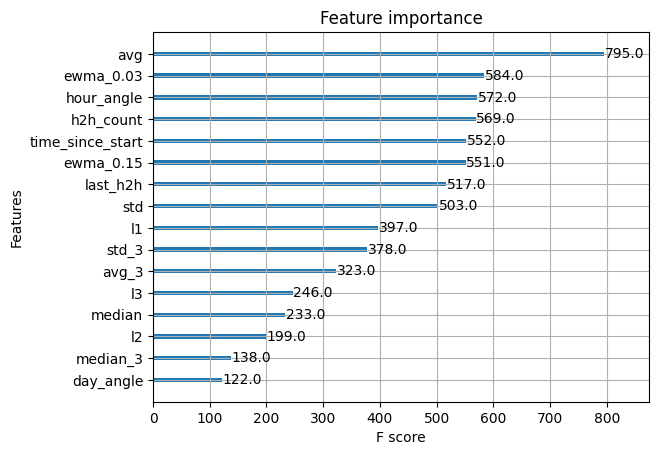

In [36]:
random_search.fit(
    train_X, train_y,
    sample_weight=pesos_treinamento,
    eval_set=[(val_X_1, val_y_1)],
    verbose=2
)

best_random_model = random_search.best_estimator_
best_random_params = random_search.best_params_

final_random_model = XGBRegressor(
    **best_random_params,
    objective='count:poisson',
    eval_metric='poisson-nloglik',
    tree_method='hist',
    early_stopping_rounds=50,
    random_state=42
)

final_random_model.fit(
    final_train_X, final_train_y,
    eval_set=[(val_X_2,val_y_2)],
    verbose=10
)
 
test_pred_random_model = final_random_model.predict(test_X)

print(60 * '-')
print('Teste:')
print(f"MAE: {mean_absolute_error(test_y, test_pred_random_model):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, test_pred_random_model)):.4f}")
print(f"Log Loss: {calculate.poisson_log_loss(test_y, test_pred_random_model):.4f}")

plot_importance(final_random_model)
plt.show()

In [37]:
#Exportar modelo para arquivo xlsx.

test_pred_df = pd.DataFrame(test_pred_random_model, columns=['lambda']).reset_index(drop=True)
test_y_df = pd.DataFrame(test_y, columns=['total_score']).reset_index(drop=True)
test_X_df = pd.DataFrame(test_X, columns=REQUIRED_FEATURES).reset_index(drop=True)
df_to_export = pd.concat([test_y_df, test_pred_df, test_X_df], axis=1)

df_to_export.to_excel(f'training_testing/dados/exports/final_random_df {datetime.now().strftime('%d-%m %H-%M')}.xlsx', index=False)


Treinamento do Modelo baseado em Grid Search

In [ ]:
grid_search.fit(train_X, train_y)

best_grid_model = grid_search.best_estimator_
best_grid_params = grid_search.best_params_

final_grid_model = XGBRegressor(
    **best_grid_params,
    early_stopping_rounds=50,
    objective='count:poisson',
    eval_metric='poisson-nloglik'
    )

final_grid_model.fit(
    final_train_X, final_train_y,
    eval_set=[(val_X_2, val_y_2)],
    verbose=10
)

test_pred_grid_model = final_grid_model.predict(test_X)


print(60 * '-')
print('Teste:')
print(f"MAE: {mean_absolute_error(test_y, test_pred_grid_model):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, test_pred_grid_model)):.4f}")
print(f"Log Loss: {calculate.poisson_log_loss(test_y, test_pred_grid_model):.4f}")

plot_importance(final_grid_model)
plt.show()


Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
[CV 1/5; 1/2916] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=0, subsample=0.8
[CV 1/5; 1/2916] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=-2.205 total time=   0.4s
[CV 2/5; 1/2916] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=0, subsample=0.8
[CV 2/5; 1/2916] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=-2.221 total time=   0.4s
[CV 3/5; 1/2916] START colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=0, subsample=0.8
[CV 3/5; 1/2916] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child

In [ ]:
#Exportar modelo para arquivo xlsx.

test_pred_df = pd.DataFrame(test_pred_random_model, columns=['lambda']).reset_index(drop=True)
test_y_df = pd.DataFrame(test_y, columns=['total_score']).reset_index(drop=True)
test_X_df = pd.DataFrame(test_X, columns=REQUIRED_FEATURES).reset_index(drop=True)
df_to_export = pd.concat([test_y_df, test_pred_df, test_X_df], axis=1)

df_to_export.to_excel(f'training_testing/dados/exports/final_random_df {datetime.now().strftime('%d-%m %H-%M')}.xlsx', index=False)
